# Ellipse fitting from center

Having a center per egg and structural segmentation we want to aproximate the egg by an ellise fuct way that it maximise the expectation being single egg. Some ellipse fitting references:
* [Fitting an Ellipse to a Set of Data Points](http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html)
* [Numerically Stable Direct Least Squares Fitting Of Ellipses](http://autotrace.sourceforge.net/WSCG98.pdf)
* [Non-linear fitting to an ellipse](http://scipython.com/book/chapter-8-scipy/examples/non-linear-fitting-to-an-ellipse/)

Borovec, J., Kybic, J., & Nava, R. (2017). **Detection and Localization of Drosophila Egg Chambers in Microscopy Images.** In Q. Wang, Y. Shi, H.-I. Suk, & K. Suzuki (Eds.), Machine Learning in Medical Imaging, (pp. 19–26).

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pylab as plt

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import segmentation.utils.data_io as tl_io
import segmentation.utils.drawing as tl_visu
import segmentation.ellipse_fitting as tl_fit

## Loading data

In [3]:
PATH_BASE = tl_io.update_path(os.path.join('images', 'drosophila_ovary_slice'))
PATH_IMAGES = os.path.join(PATH_BASE, 'image')
PATH_SEGM = os.path.join(PATH_BASE, 'segm')
PATH_ANNOT = os.path.join(PATH_BASE, 'annot_eggs')
PATH_CENTRE = os.path.join(PATH_BASE, 'center_levels')
COLORS = 'bgrmyck'

### Loading images...

In [4]:
name = 'insitu7545'
# name = 'insitu11151'
img = np.array(Image.open(os.path.join(PATH_IMAGES, name + '.jpg')))
seg = np.array(Image.open(os.path.join(PATH_SEGM, name + '.png')))
centers = pd.DataFrame.from_csv(os.path.join(PATH_CENTRE, name + '.csv')).values
centers = centers[:, [1, 0]]
FIG_SIZE = (10. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]

Visualisation of structure segmentation overlped over input image and marked center points.

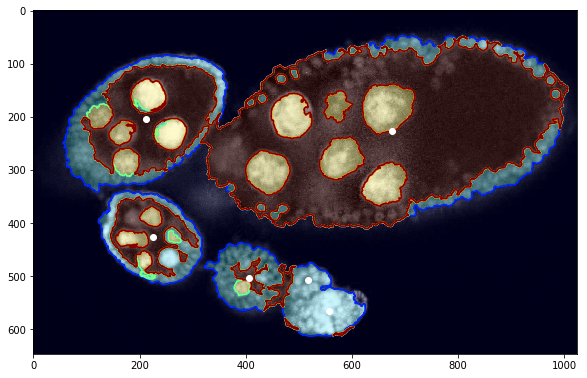

In [5]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.imshow(seg, alpha=0.2, cmap=plt.cm.jet), plt.contour(seg, cmap=plt.cm.jet)
_= plt.plot(centers[:, 1], centers[:, 0], 'ow')

## Preprocess - estimate boundary points

Visualisation of labeled sample points according structure segmentation / annotations.

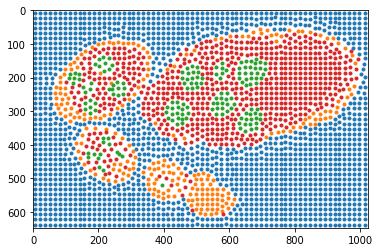

In [6]:
slic, points_all, labels = tl_fit.get_slic_points_labels(seg, size=15, regul=0.3)
# points_all, labels = egg_segm.get_slic_points_labels(seg, img, size=15, regul=0.25)
for lb in np.unique(labels):
    plt.plot(points_all[labels == lb, 1], points_all[labels == lb, 0], '.')
_= plt.xlim([0, seg.shape[1]]), plt.ylim([seg.shape[0], 0])
weights = np.bincount(slic.ravel())

Reconstruction of boundary points using ray features from centers.

In [7]:
points_centers = tl_fit.prepare_boundary_points_ray_edge(seg, centers, close_points=5)
# points_centers = tl_fit.prepare_boundary_points_ray_mean(seg, centers, close_points=5)
# points_centers = tl_fit.prepare_boundary_points_dist(seg, centers)

((0.0, 1024.0, 647.0, 0.0), None)

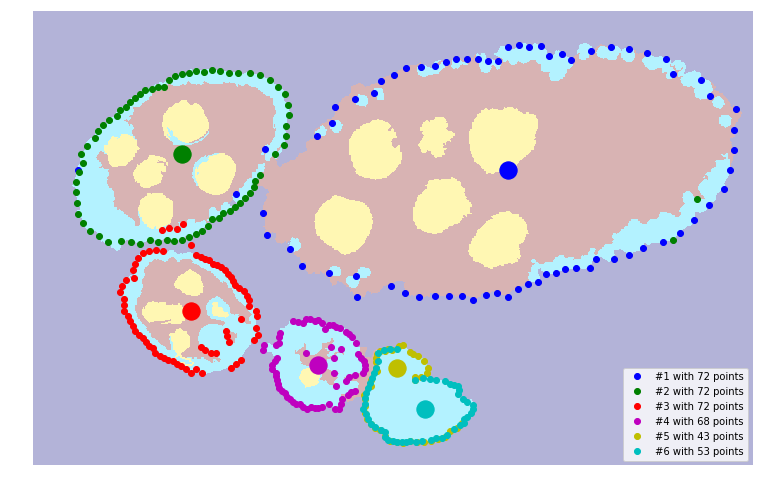

In [8]:
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(seg, alpha=0.3, cmap=plt.cm.jet)
for i, points in enumerate(points_centers):
    plt.plot(points[:, 1], points[:, 0], 'o', color=COLORS[i % len(COLORS)], label='#%i with %i points' % ((i + 1), len(points)))
for i in range(len(centers)):
    # plt.plot(centers[i, 1], centers[i, 0], 'o', color=COLORS[i % len(COLORS)])
    plt.scatter(centers[i, 1], centers[i, 0], s=300, c=COLORS[i % len(COLORS)])
_= plt.legend(loc='lower right'), plt.axes().set_aspect('equal')
_= plt.xlim([0, seg.shape[1]]), plt.ylim([seg.shape[0], 0])
plt.axis('off'), fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
# fig.savefig('fig1.pdf')

## Fit ellipse by RANDSAC and hypothesis

Set the probability of being egg for each class from initial segmentation. 

In [9]:
TABLE_FB_PROBA = [[0.01, 0.7, 0.95, 0.8],
                  [0.99, 0.3, 0.05, 0.2]]
print ('points:', len(points_all), 'weights:', len(weights), 'labels:', len(labels))

points: 2652 weights: 2652 labels: 2652


Fit the ellpse to maximise the hypoteses having single egg inside.

model params: (226, 666, 344, 167, 1.7484794783105475)
-> crit: -231578.882203
model params:

 (207, 225, 169, 109, 1.9646633052007403)
-> crit: -52477.3291955
model params:

 (426, 222, 75, 103, -0.6433105348717449)
-> crit: -23629.7445445
model params:

 (503, 403, 61, 65, -0.722148250871737)
-> crit: -8080.07609603
model params:

 (550, 536, 63, 74, -0.6988075609479609)
-> crit: -6592.2515825
model params:

 (561, 541, 75, 52, 1.4110005865137059)
-> crit: -8428.83115715


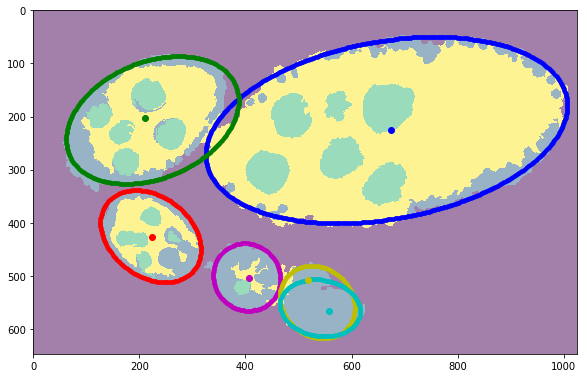

In [10]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(seg, alpha=0.5)
ellipses, crits = [], []
for i, points in enumerate(points_centers):
    model, _ = tl_fit.ransac_segm(points, tl_fit.EllipseModelSegm, points_all, weights,  labels, 
                                  TABLE_FB_PROBA, min_samples=0.4, residual_threshold=10, max_trials=150)
    if model is None: continue
    c1, c2, h, w, phi = model.params
    ellipses.append(model.params)
    crit = model.criterion(points_all, weights, labels, TABLE_FB_PROBA)
    crits.append(np.round(crit))
    print ('model params:', (int(c1), int(c2), int(h), int(w), phi))
    print ('-> crit:', model.criterion(points_all, weights, labels, TABLE_FB_PROBA))
    rr, cc = tl_visu.ellipse_perimeter(int(c1), int(c2), int(h), int(w), phi)
    plt.plot(cc, rr, '.', color=COLORS[i % len(COLORS)])

# plt.plot(centers[:, 1], centers[:, 0], 'o')
for i in range(len(centers)):
    plt.plot(centers[i, 1], centers[i, 0], 'o', color=COLORS[i % len(COLORS)])
_= plt.xlim([0, seg.shape[1]]), plt.ylim([seg.shape[0], 0])

### Visualizations

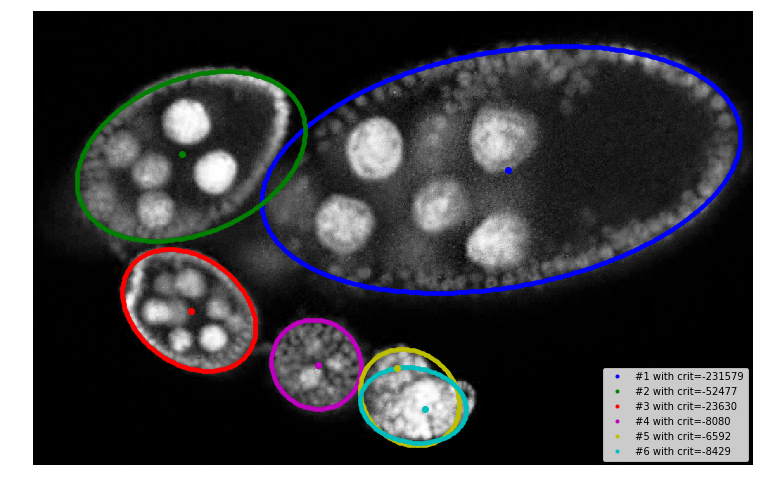

In [11]:
fig = plt.figure(figsize=FIG_SIZE)
# plt.imshow(img)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
for i, params in enumerate(ellipses):
    c1, c2, h, w, phi = params
    rr, cc = tl_visu.ellipse_perimeter(int(c1), int(c2), int(h), int(w), phi)
    plt.plot(cc, rr, '.', color=COLORS[i % len(COLORS)], label='#%i with crit=%d' % ((i + 1), int(crits[i])))
plt.legend(loc='lower right')

# plt.plot(centers[:, 1], centers[:, 0], 'ow')
for i in range(len(centers)):
    plt.plot(centers[i, 1], centers[i, 0], 'o', color=COLORS[i % len(COLORS)])
plt.xlim([0, seg.shape[1]]), plt.ylim([seg.shape[0], 0])
_= plt.axis('off'), fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
# fig.savefig('fig2.pdf')

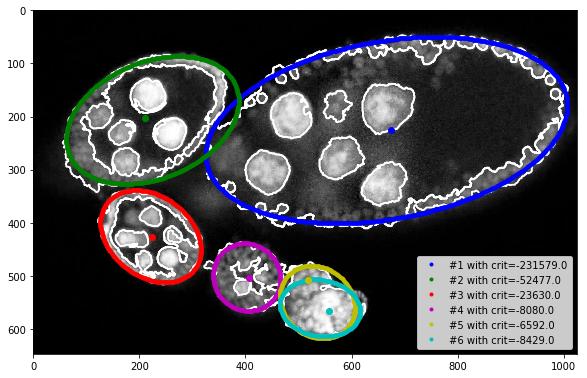

In [12]:
plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.contour(seg, colors='w') #, plt.imshow(seg, alpha=0.2)
for i, params in enumerate(ellipses):
    c1, c2, h, w, phi = params
    rr, cc = tl_visu.ellipse_perimeter(int(c1), int(c2), int(h), int(w), phi)
    plt.plot(cc, rr, '.', color=COLORS[i % len(COLORS)], label='#%i with crit=%.1f' % ((i + 1), crits[i]))
plt.legend(loc='lower right')

# plt.plot(centers[:, 1], centers[:, 0], 'ow')
for i in range(len(centers)):
    plt.plot(centers[i, 1], centers[i, 0], 'o', color=COLORS[i % len(COLORS)])
_= plt.xlim([0, seg.shape[1]]), plt.ylim([seg.shape[0], 0])